<a href="https://colab.research.google.com/github/yoniamit/batlocations/blob/main/batlocations080421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [91]:
#Imports
import math
from datetime import datetime
import numpy as np



#Definations

xlb = 320.0  # x left basket
ylb = 410.0  # y left basket
xrb = 420.0  # x right basket
yrb = 60.0  # y right basket
basketradius = 40.0  # distance from the center of the basket which count as "IN"
accuracy_limit = 0.0  # Value for accuracy check #הוספתי
data_read_path = "/content/drive/MyDrive/Python files/20210311-161231IrTimes.txt" #path_of data to read
#data_read_path =  "/content/drive/MyDrive/Python files/20210223-205817IrTimes.txt"

nans_tresh  = 0.3
per_unit = 60






In [92]:
def load_raw_file(path):
  f = open(data_read_path, "r")
  data = Lines = f.readlines()
  list_locations = []
  
  for line in data:
      columns = line.split(",")
      #print(columns[13] + " " + columns[14])

      xydata = columns[14].split(" ")
      xydata = [x for x in xydata if x]
      xy_accuracy_data = columns[15].split(" ")  # הוספתי
      xy_accuracy_data = [x for x in xy_accuracy_data if x]  # הוספתי
      if (len(xydata) != 2) or (len(xy_accuracy_data) != 2):  # הוספתי
          continue

      x_accuracy_data = (float(xy_accuracy_data[0].replace("[", "").replace("]", "")))  # הוספתי
      y_accuracy_data = (float(xy_accuracy_data[1].replace("[", "").replace("]", "")))  # הוספתי
      if (y_accuracy_data > accuracy_limit) or (x_accuracy_data > accuracy_limit):  # הוספתי
          continue

      x = (float(xydata[0].replace("[", "").replace("]", "")))
      y = (float(xydata[1].replace("[", "").replace("]", "")))
      dt = datetime.strptime(columns[0] + " " + columns[1] ,  "%Y%m%d %H%M%S").timestamp()  #20210104
      t = np.array([int(columns[13]), dt, x, y])
      list_locations += [t]

  list_array = np.array(list_locations)

  f.close()

  print("Done! func1!")

  return list_array





In [93]:
def time_arrange_data(list_array):
  t = 0
  minimum_time = np.min(list_array[:,1])
  maximum_time = np.max(list_array[:,1])
  time_now = minimum_time
  list_tag = np.unique(list_array[:,0])
  main_data = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit), 2))




  print(list_array[:,1])
  print(minimum_time, maximum_time)
  print(type(list_tag[0]))

  tagids  = list_array[:,0]
  dates = list_array[:,1]


  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      main_data[a,t,:] = np.mean(list_array[(tagids == list_tag[a]) & (dates> time_now) & (dates< (time_now + per_unit)) ,2:4],axis = 0)
    t += 1  
    time_now += per_unit

  tag_nans = np.zeros((len(list_tag)))
  for a in range(len(list_tag)):
    tag_nans[a] = len(main_data[a,np.isnan(main_data[a,:,0]),0])/len(main_data[a,:,0]) > nans_tresh 

  main_data = main_data[~tag_nans.astype(bool)]
  list_tag = list_tag[~tag_nans.astype(bool)]


  print("Done! func2!")
  return main_data, list_tag

In [94]:


main_data, list_tag = time_arrange_data(load_raw_file(data_read_path))
print(list_tag)
print("Done! Part1!")


Done! func1!
[1.61547915e+09 1.61547915e+09 1.61547915e+09 ... 1.61593406e+09
 1.61593572e+09 1.61593577e+09]
1615479152.0 1615935768.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[0. 2. 3. 5.]
Done! Part1!


In [96]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]



In [97]:
for a in range(len(list_tag)):
    y = main_data[a,:,:]
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    main_data[a,:,:] = y
print("Done! Part3!")

Done! Part3!


In [98]:
import matplotlib.pyplot as plt
batid=6
plt.figure()
plt.scatter(main_data[batid,:, 0], main_data[batid,:, 1])
plt.show()

IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [99]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(main_data[6,:,0])
plt.show()

IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [100]:


time_now = minimum_time
t = 0
distance_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

while time_now <= (maximum_time - per_unit):
  for a in range(len(list_tag)):
    my_pos = main_data[a,t,:]
    all_pos = main_data[:,t,:]
    other_bats_pos = np.delete(all_pos,a, 0)
    dist = []
    for pos in other_bats_pos:
      dist += [np.mean(np.linalg.norm(my_pos - pos))]
    dist = np.array(dist)
    dist = np.mean(dist)
    distance_array[a,t] = dist
  t += 1  
  time_now += per_unit

print(distance_array)

[[247.75048212 244.37961438 191.11708509 ...   7.77192646  10.9613417
   46.08498554]
 [359.98239043 358.61177051 351.39719068 ...   8.63633556   5.54556226
   39.97832817]
 [216.40807716 214.51139945 196.90959987 ...   7.81145996   4.97893204
  103.22872396]
 [273.29941314 269.48724802 243.99240195 ...   9.79718873   4.73622233
   39.05566127]]


In [101]:
time_now = minimum_time + per_unit
t = 1
movment_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

while time_now <= (maximum_time - per_unit):
  for a in range(len(list_tag)):
    my_pos = main_data[a,t,:]
    mt_prev_pos = main_data[a,t -1,:]
    thedistance = np.linalg.norm(my_pos - mt_prev_pos)
    movment_array[a,t-1] = (thedistance )
  t += 1  
  time_now += per_unit

print(movment_array)
correlations = []
for a in range(len(list_tag)):
  correlations.append(np.correlate(movment_array[a,:],distance_array[a,:]))


correlations = np.array(correlations)
print(correlations)
print(list_tag)

[[7.49615669e+00 8.37556357e+01 1.47330439e+02 ... 1.57134840e-01
  1.30052221e+00 0.00000000e+00]
 [9.88827713e+00 4.64991703e+00 1.85523853e+00 ... 5.47596106e-02
  5.54930130e+00 0.00000000e+00]
 [3.32034566e+00 3.11486009e+00 7.11345560e+01 ... 1.11803399e+01
  9.87110812e+01 0.00000000e+00]
 [3.41443630e-01 4.52753961e-01 1.10790939e+01 ... 1.97465948e+00
  2.81513765e+00 0.00000000e+00]]
[[14589349.58311252]
 [12238630.73576199]
 [23474832.7265187 ]
 [ 9681047.28447926]]
[0. 2. 3. 5.]


[[500.06363144 350.07147761]
 [348.29761615 297.81540821]
 [492.98724281 142.39960667]]
[0.44225522 0.17900757 0.37873721]


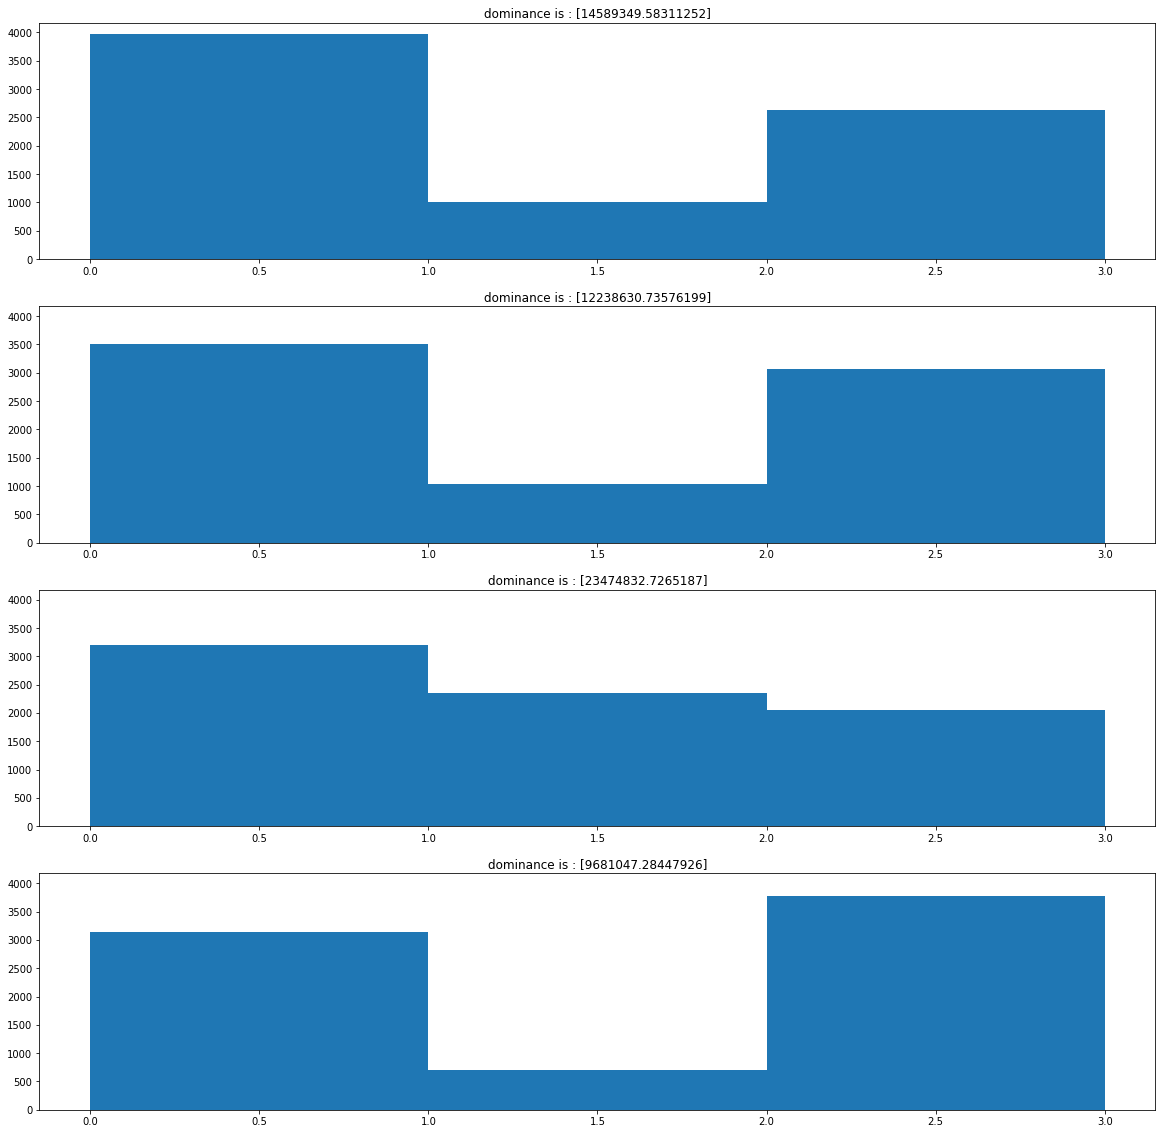

In [102]:
import numpy as np
from sklearn.mixture import GaussianMixture
maindatashape = np.shape(main_data)
f = np.reshape([main_data[:,:,:] ] , (maindatashape[0]*maindatashape[1] , 2) )
gmmcomp = 3
gm = GaussianMixture(n_components=gmmcomp, random_state=0).fit( f )
print(gm.means_)
print(gm.weights_)

fig , axs= plt.subplots(len(list_tag) ,figsize=(20,20), sharey=True)
for a in range(len(list_tag)):
    gmpred = gm.predict(main_data[a,:,:])
    
    axs[a].set_title("dominance is : " + str(correlations[a]))
    axs[a].hist(gmpred , bins = range(gmmcomp+1))
fig.savefig('result1.png')


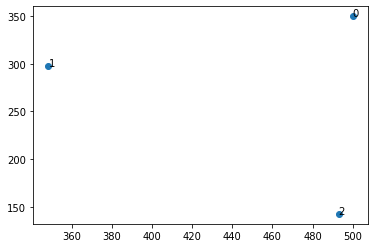

In [107]:
import matplotlib.pyplot as plt

fig= plt.figure()

f = np.array(range(gmmcomp))
for i, txt in enumerate(f):
    plt.annotate(txt, (gm.means_[i,0], gm.means_[i,1]))
    
plt.scatter(gm.means_[:, 0], gm.means_[:, 1])
plt.show()
fig.savefig('mapofplaces.png')

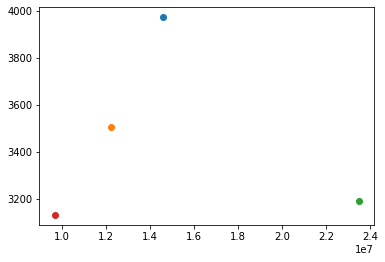

In [111]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==0]))
    
fig.savefig('dominanceVsHome0.png')

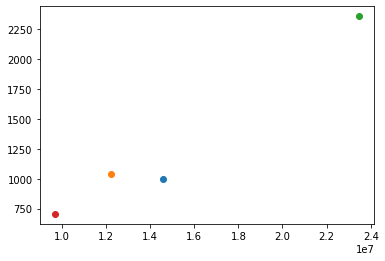

In [112]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==1]))
    
fig.savefig('dominanceVsHome1.png')

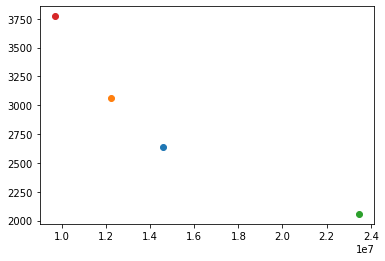

In [113]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==2]))
    
fig.savefig('dominanceVsHome2.png')